In [0]:
import tensorflow as tf
from google.cloud import storage
import os
from glob import glob
from google.colab import auth
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray, rgb2lab
auth.authenticate_user()


!apt install aria2 -y
!aria2c -j 16 "http://files.fast.ai/data/imagenet-sample-train.tar.gz"
!tar -xvf imagenet-sample-train.tar.gz

In [0]:
def imshow(image):
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(image)

In [3]:
train_image_paths = sorted(
    glob('train/*/*'))
bad = 0
print('Found  {} training images'.format(len(train_image_paths)))

Found  19439 training images


In [0]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def intlist_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def floatlist_feature(value_list):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value_list))

def make_example(image_path):
    image = imread(image_path)
    image = cv2.resize(image, (256, 256))
    image_grayscale = rgb2gray(image.copy())
    image_lab = rgb2lab(image.copy())
    feature = {
        'image_grayscale' : floatlist_feature(image_grayscale.flatten().tolist()),
        'image_lab': floatlist_feature(image_lab.flatten().tolist())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(image_list, path=''):
    global bad
    with tf.io.TFRecordWriter(path) as writer:
        for image_path in tqdm_notebook(image_list, total=len(image_list)):
            try:
                example = make_example(image_path)
                writer.write(example.SerializeToString())
            except:
                bad += 1            
            
def create_dataset(images, prefix='', folder='data', n_shards=8):
    n_samples = len(images)
    step_size = n_samples//n_shards + 1
    for i in range(0, n_samples, step_size):
        path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
        write_tfrecord(images[i:i+step_size], path)

In [0]:
!mkdir tfrecords
write_tfrecord(train_image_paths[:100], path='tfrecords/train.tfrecord')
bad

In [0]:
feature_description = {
    'image_grayscale' : tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
    'image_lab': tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True)
}

def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image_grayscale = parsed_example['image_grayscale']
    image_lab = parsed_example['image_lab']
    return image_grayscale, image_lab


train_files = tf.data.Dataset.list_files('tfrecords/*')
train_dataset = train_files.interleave(tf.data.TFRecordDataset, 
                                       cycle_length=4, 
                                       block_length=16,
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
with tf.Session() as sess:
    x = sess.run(train_dataset.make_one_shot_iterator().get_next())

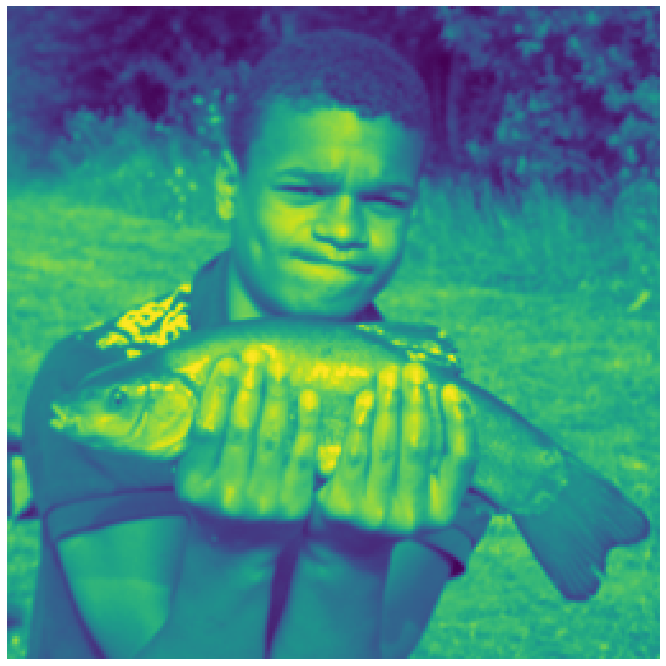

In [7]:
img_g = np.reshape(x[0], (256, 256))
img_l = np.reshape(x[1], (256, 256, 3))
imshow(img_g)

In [0]:
!mkdir colorizer
create_dataset(train_image_paths, prefix='train', folder='colorizer', n_shards=8*2)

In [11]:
storage_client = storage.Client()
buckets = list(storage_client.list_buckets())
buckets

[<Bucket: srihari-datasets>]

In [12]:
for file in glob('colorizer/*'):
    blob = buckets[0].blob(file) 
    print('uploading file', file)
    blob.upload_from_filename(file)

uploading file colorizer/train_00014.tfrecords
uploading file colorizer/train_0001.tfrecords
uploading file colorizer/train_0002.tfrecords
uploading file colorizer/train_0005.tfrecords
uploading file colorizer/train_0006.tfrecords
uploading file colorizer/train_0009.tfrecords
uploading file colorizer/train_0000.tfrecords
uploading file colorizer/train_00010.tfrecords
uploading file colorizer/train_0003.tfrecords
uploading file colorizer/train_00011.tfrecords
uploading file colorizer/train_00012.tfrecords
uploading file colorizer/train_00015.tfrecords
uploading file colorizer/train_0004.tfrecords
uploading file colorizer/train_00013.tfrecords
uploading file colorizer/train_0007.tfrecords
uploading file colorizer/train_0008.tfrecords
